In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
import warnings

warnings.filterwarnings('ignore')

### Функция расчета r2-score и метод градиентного бустинга

В результате экспетиментов в качестве модели выбран "Градиентный бустинг".

Так как среди признаков много категориальных, то подстроение случайного леса, основанное на выборке параметров методом бутстрап, работает плохо, так как некоторые деревья при этом строятся только на категориальных переменных. Поэтому в алгоритм внесены изменения, так чтобы дерево всегда строилось на всем множетстве переменных - тесты показали, что в этом случае результат получается лучше.

В качестве гиперпараметров оставлены только глубина дерева и количество деревьев, как наиболее существенно влияющие на результат.

In [39]:
def my_r2_score(y_true, y_pred):
    n = y_true.shape[0]
    y_mean = np.sum(y_true)/n
    
    sum1 = 0
    sum2 = 0
    for i in range(n):
        sum1 += (y_true[i] - y_pred[i])**2
        sum2 += (y_true[i] - y_mean)**2
    return 1 - sum1 / sum2

In [40]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)     

class OurDecisionTreeRegressor:
    def __init__(
        self, 
        max_depth: int = 0):
        
        self.max_depth = max_depth
        self.cur_leaf = 0
        self.depth = 0
        self.cur_leaf = 0
        self.tree = None
        
    def fit(self, data, labels):
        
        self.tree = self.build_tree(data, labels, 0)
        return self
    
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes
    
    
    def build_tree(self, data, labels, cur_depth):


        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        #  Ограничение на глубину дерева
        if cur_depth >= self.max_depth:
            return Leaf(data, labels)


        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        self.depth += 1
        
        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, cur_depth + 1)
        false_branch = self.build_tree(false_data, false_labels, cur_depth + 1)
        

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_criter = self.criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features): 
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criter)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    # Разбиение датасета в узле
    @staticmethod
    def split(data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет качества
    def quality(self, left_labels, right_labels, current_criter):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criter - p * self.criterion(left_labels) - \
                (1 - p) * self.criterion(right_labels)
    
    # Расчет критерия Джини или Энтропии
    @staticmethod
    def criterion(labels):
        return np.var(labels)
    
    # классификация объектов
    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

In [41]:
class OurGBoostRegressor:
    def __init__(
        self,
        n_trees: int = 3,
        max_depth: int = 3,
        coefs: list =  [1] * 3,
        eta: float = 0.1):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []
        
    def fit(self, X_train, y_train):
        self = self.gb_fit(X_train, y_train)
        return self
    
    def predict(self, X: np.array):
        return self.gb_predict(X)
    
    def gb_fit(self, X_train, y_train):
    
        # Деревья будем записывать в список
        self.trees = []

        for i in range(self.n_trees):
            tree = OurDecisionTreeRegressor(max_depth=self.max_depth)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

            self.trees.append(tree)

        return self
    
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])
    
    @staticmethod
    def bias(y, z):
        return (y - z)

### Подготовка данных

In [42]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df = pd.concat([train_data, test_data], axis=0)

In [43]:
df.head()

,Id,age,biology,chemistry,english,geography,history,lesson_price,mean_exam_points,physics,qualification,years_of_experience
0,0,40.0,0.0,0.0,0.0,1.0,0.0,1400.0,63.0,1.0,1.0,0.0
1,1,48.0,0.0,0.0,0.0,0.0,0.0,2850.0,86.0,1.0,3.0,4.0
2,2,39.0,0.0,0.0,0.0,0.0,0.0,1200.0,53.0,0.0,1.0,0.0
3,3,46.0,0.0,0.0,0.0,0.0,0.0,1400.0,56.0,0.0,1.0,5.0
4,4,43.0,0.0,0.0,0.0,0.0,0.0,1500.0,59.0,0.0,1.0,1.0


Посчитаем базовые статистики по набору данных

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,20000.0,9999.50000,5773.647028,0.0,4999.75,9999.5,14999.25,19999.0
age,20000.0,45.92540,8.000165,23.0,41.00,46.0,51.00,68.0
biology,20000.0,0.11485,0.318849,0.0,0.00,0.0,0.00,1.0
chemistry,20000.0,0.12820,0.334321,0.0,0.00,0.0,0.00,1.0
english,20000.0,0.05485,0.227693,0.0,0.00,0.0,0.00,1.0
geography,20000.0,0.03175,0.175338,0.0,0.00,0.0,0.00,1.0
history,20000.0,0.01890,0.136175,0.0,0.00,0.0,0.00,1.0
lesson_price,20000.0,1698.10000,524.562578,200.0,1300.00,1500.0,2150.00,4050.0
mean_exam_points,10000.0,64.34080,13.536823,32.0,55.00,63.0,73.00,100.0
physics,20000.0,0.37815,0.484937,0.0,0.00,0.0,1.00,1.0


In [45]:
discrete_feature = [
    feature for feature in df.select_dtypes(include=[np.number])
    if len(df[feature].unique())<25 and feature != 'choose'
]
discrete_feature

['biology',
 'chemistry',
 'english',
 'geography',
 'history',
 'physics',
 'qualification',
 'years_of_experience']

Посмотрим распределение среднего значения целевой переменной в группировке по дискретным признакам

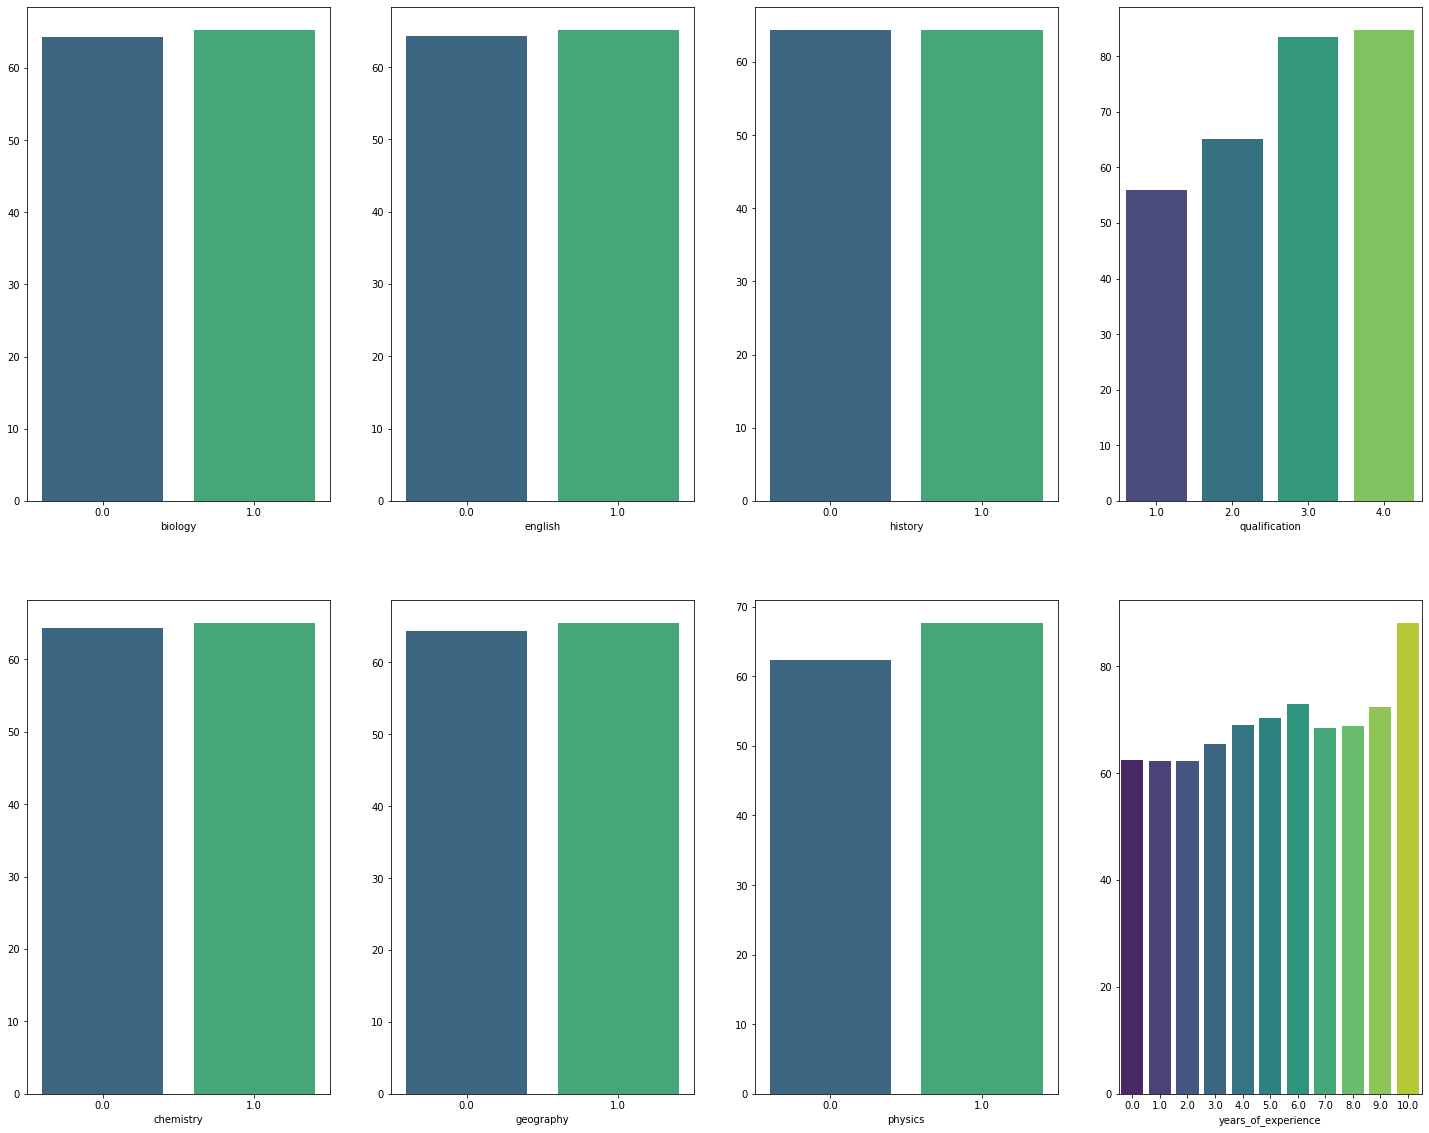

In [46]:
ig, axes = plt.subplots(2, 4, figsize=(25, 20))

for num, feature in enumerate(discrete_feature):
    data = train_data.copy()
    statistics = data.groupby([feature])["mean_exam_points"].mean()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%2, num//2]
    )

И распределение значений дискретных признаков на трейне и тесте

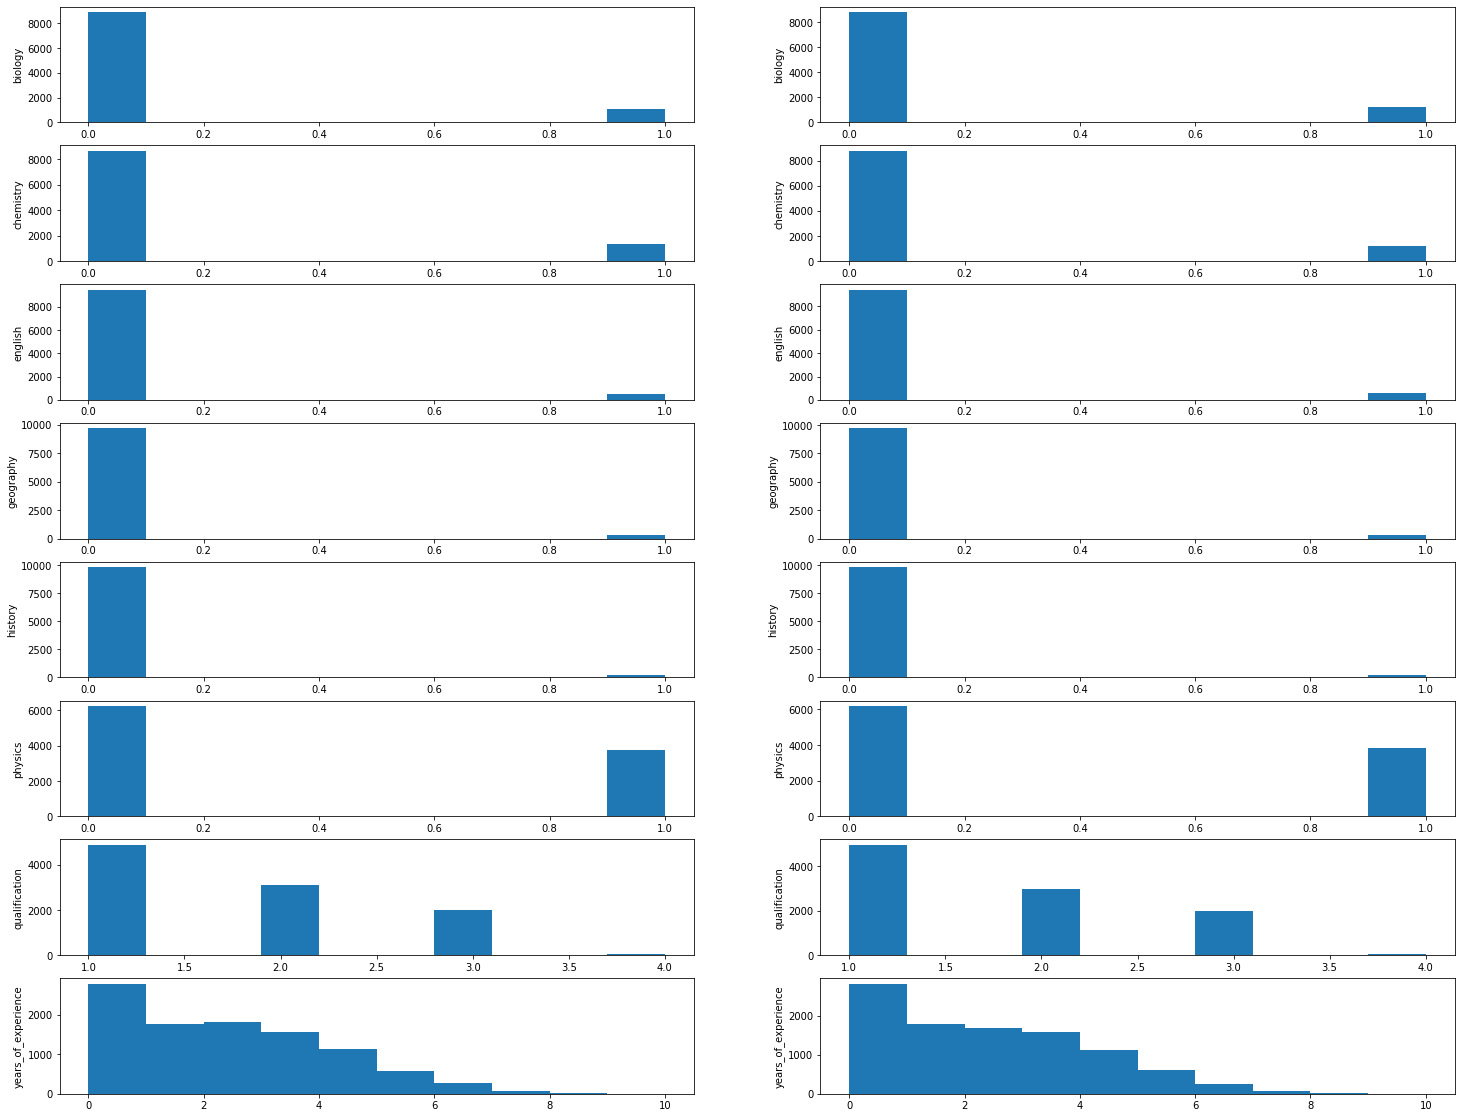

In [47]:
ig, axes = plt.subplots(8, 2, figsize=(25, 20))

for num, feature in enumerate(discrete_feature):
    data = df[np.isnan(df.mean_exam_points)==False].copy()
    axes[num, 0].hist(data[feature])
    axes[num, 0].set_ylabel(feature)

for num, feature in enumerate(discrete_feature):
    data = df[np.isnan(df.mean_exam_points)==True].copy()
    axes[num, 1].hist(data[feature])
    axes[num, 1].set_ylabel(feature)

Видим, что из трех показателей, относящихся к предметам, влияние оказывает только физика.

In [48]:
df.groupby(['qualification'], as_index=False).agg({'mean_exam_points':['mean', 'count']})

qualification mean_exam_points      
                            mean count
0           1.0        55.919328  4884
1           2.0        65.056689  3087
2           3.0        83.494189  1979
3           4.0        84.660000    50

Значений для qualification = 4 очень мало, объединим их со значениями 3.

In [49]:
df['qualification2'] = df['qualification'].apply(lambda x: min(x, 3))

Так как их общих соображений очевидно, что на цену урока влияет уровень квалификации преподавателя, очистим показатель lesson_price от этого влияния, разделив на значение медианы цены урока в разрезе каждого уровны квалификации.
Так же из общих соображений можно было бы тем же методом очистить от влияния стажа, но тесты показывают, что в этом случае модель начинает работать хуже. Поэтому оставляет только отношение lesson_price к медиане по qualification, и отдельно переменную years_of_experience.

In [50]:
df2 = df.groupby(['qualification'], as_index=False).agg({'lesson_price':'median'})
df2.rename(columns={'lesson_price': 'qualif_lesson_price_median'} , inplace=True)
df2

,qualification,qualif_lesson_price_median
0,1.0,1350.0
1,2.0,1700.0
2,3.0,2350.0
3,4.0,2400.0


In [51]:
df = df.merge(df2, on='qualification', how='left')
df['qualif_lesson_price'] = df.lesson_price/df.qualif_lesson_price_median

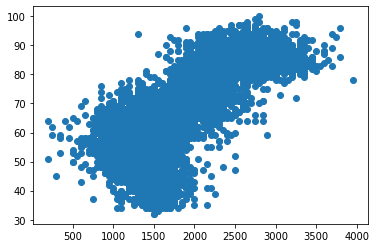

In [52]:
plt.scatter(df.lesson_price, df.mean_exam_points)

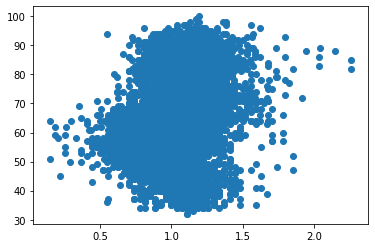

In [53]:
plt.scatter(df.qualif_lesson_price, df.mean_exam_points)

Существенного влияния показатель "возраст" на модель не обнаружено, поэтому далее он не используется

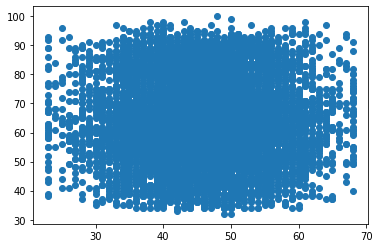

In [54]:
plt.scatter(train_data.age, train_data.mean_exam_points)

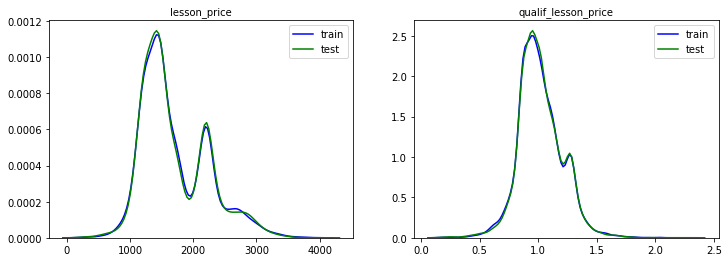

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for num, feature in enumerate(['lesson_price','qualif_lesson_price']):
    try:
        train, test = df.loc[np.isnan(df.mean_exam_points)==False, feature].copy(), df.loc[np.isnan(df.mean_exam_points)==True, feature].copy()
        sns.kdeplot(train, ax=axes[num%2], color="blue", label="train")
        sns.kdeplot(test, ax=axes[num%2], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train = df.loc[np.isnan(df.mean_exam_points)==False, feature].copy()
        sns.kdeplot(train, ax=axes[num%2], color="blue", label="train")
    axes[num%2].set_title(feature, fontsize=10)

Видим, что распределение непрерывных показателей практически совпадает для трейна и теста. За счет нормирования на квалицикацию удается сгладить график, убрав "горбик". Теоретически выглядит логичным нормировать lesson_price еще и на медиану в группировке по years_of_experience, то есть исключить из средней цены влияние не только квалификации преподавателя, но и его опыт, то тесты показали, что модель в этом случае работает хуже.

### Обучение модели

In [56]:
feature_names = [
 'physics',
 'qualification2',
 'years_of_experience',
 'qualif_lesson_price'
]

target_name = 'mean_exam_points'

In [57]:
def model_prepare(df, test_size, feature_names, target_name):
    

    X = df.loc[np.isnan(df.mean_exam_points)==False, feature_names]
    y = df.loc[np.isnan(df.mean_exam_points)==False, target_name]

    if test_size > 0:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)
    else:
        X_train = X
        y_train = y
        X_valid = None
        y_valid = None

    # Число деревьев в ансамбле
    n_trees = 54

    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees

    # Максимальная глубина деревьев
    max_depth = 4

    # Шаг
    eta = 0.2


    OurGBR = OurGBoostRegressor(n_trees, max_depth, coefs, eta)
    OurGBR.fit(X_train.values, y_train.values)
    
    return OurGBR, X_train, y_train, X_valid, y_valid

In [58]:
OurGBR, X_train, y_train, X_valid, y_valid = model_prepare(df, 0.3, feature_names, target_name)

In [60]:
y_pred = OurGBR.predict(X_valid.values)
y_pred_train = OurGBR.predict(X_train.values)

In [62]:
(my_r2_score(y_train.values, y_pred_train), my_r2_score(y_valid.values, y_pred))

(0.7946186696563369, 0.7814143369515253)

In [63]:
OurGBR, X_train, y_train, X_valid, y_valid = model_prepare(df, 0, feature_names, target_name)

### Выгрузка результатов

In [64]:
X_test = df.loc[np.isnan(df.mean_exam_points), feature_names + ['Id']]

X_test["mean_exam_points"] = OurGBR.predict(X_test[feature_names].values)

y_test = X_test.loc[:, ['Id', 'mean_exam_points']]

y_test.to_csv('Zharova_Natalija_predictions.csv', index=False)